
# Creating Activation Atlases with captum.optim

This notebook demonstrates the use of the captum.optim submodule for creation of [Activation Atlases](https://distill.pub/2019/activation-atlas/) for the InceptionV1 model imported from Caffe.


In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll define some helper functions:

In [4]:
from typing import Tuple, Optional
from PIL import Image


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    """
    Show CHW & NCHW tensors as an image.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        figsize (Tuple[int, int], optional): height & width to use
            for displaying the image figure.
        scale (float): Value to multiply the input tensor by so that
            it's value range is [0-255] for display.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def save_tensor_as_image(x: torch.Tensor, filename: str, scale: float = 255.0) -> None:
    """
    Save CHW & NCHW image tensors as images.
    Args:
        x (torch.Tensor): The tensor you want to save as an image.
        filename (str): The filename to use when saving the image.
        scale (float, optional): Value to multiply the input tensor by so that
            it's value range is [0-255] for saving.
    """
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.clone().detach().cpu().permute(1, 2, 0) * scale
    colorspace = "RGB" if x.shape[2] == 3 else "RGBA"
    im = Image.fromarray(x.numpy().astype(np.uint8), colorspace)
    im.save(filename)


def get_top_class_indices(attributions: torch.Tensor, class_idx: int) -> torch.Tensor:
    """
    Args:
      attributions (torch.Tensor): A set of attributions that correspond to a set of
          activation samples.
      class_idx (int): The target class id.
    Returns:
      indices (torch.Tensor): A set of indices for the top idx for the target class.
    """
    assert attributions.dim() == 2
    return torch.tensor(
        [
            i
            for i, attr in enumerate(attributions)
            if class_idx in torch.argsort(-attr)[0:1]
        ],
        device=attributions.device,
    )


def get_postive_class_indices(
    attributions: torch.Tensor, class_idx: int, num_indices: int
) -> torch.Tensor:
    """
    Args:
      attributions (torch.Tensor): A set of attributions that correspond to a set of
          activation samples.
      class_idx (int): The target class id.
      num_indices (int): The number of top indices to collect.
    Returns:
      indices (torch.Tensor): A set of indices where the top idx is the target class.
    """
    assert attributions.dim() == 2
    indices = torch.argsort(-attributions[:, class_idx])[0:num_indices]
    positive = attributions[indices, class_idx] > 0
    return indices[positive]


def create_alpha_mask(
    h: int, w: int, vec_coords, device: torch.device = torch.device("cpu")
) -> torch.tensor:
    """
    Create an alpha mask to make an activation atlas background transparent.

    Args:
       h (int): The height of each cell.
       w (int): the width of each cell.
       device (torch.device): The device that the cells are on.
    Returns:
       alpha_mask (torch.Tensor): An alpha mask tensor used to make an atlas
           background transparent.
    """

    return optimviz.atlas.create_atlas(
        [torch.ones(1, 1, h, w, device=device) for n in vec_coords],
        vec_coords,
        grid_size=grid_size,
        base_tensor=torch.zeros,
    )

Download the precollected samples & their corresponding attributions:


In [ ]:
fileurl = "mixed5b_layer_samples.pt"
m5b_activation_samples = torch.hub.download_url_to_file(
    fileurl, "mixed5b_layer_samples.pt", progress=True
).to(device)
fileurl = "mixed5b_samples_attributions.pt"
m5b_activation_sample_attributions = torch.hub.download_url_to_file(
    fileurl, "mixed5b_samples_attributions.pt", progress=True
).to(device)

## Sample Filtering

Unlike a normal activation atlas, we need to filter out samples that aren't related to the desired class id. Below we only collect the samples that are related to scuba divers, but there are plenty of other classes to choose from.

In [8]:
# 6 grey whale
# 62 red fox
# 76 tiger
# 442 great white shark
# 671 frying pan
# 672 wok
# 235 fireboat
# 287 streetcar
# 982 scuba diver
# 507 snorkel
# 547 abacus
# 930 comic book
# 600 spider web
# 643 monarch

class_id = 982

class_indices = get_top_class_indices(sample_attributions, class_id)
positive_class_indices = get_postive_class_indices(sample_attributions, class_id, 3000)
combined_indices = torch.cat((class_indices, positive_class_indices), 0)

# Filter out nonselected activation samples
filtered_samples = activation_samples[combined_indices]

## Dimensionality Reduction For Activation Atlas Grid Creation

With our dataset activation samples for the Mixed5b layer, we can use either UMAP or Sklearn's TSNE to reduce the number of channels to 2. Having only two channels will let us treat the activation samples as x and y positions on a graph. 

Before graphing the reduced activation samples, we normalize them in order to remove outliers. Note that we only need to normalize the graph when we want to plot it using a graphing library like `matplotlib`.

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.01, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=20,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sun Mar 14 17:11:29 2021 Finding Nearest Neighbors
Sun Mar 14 17:11:32 2021 Finished Nearest Neighbor Search
Sun Mar 14 17:11:33 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epoch

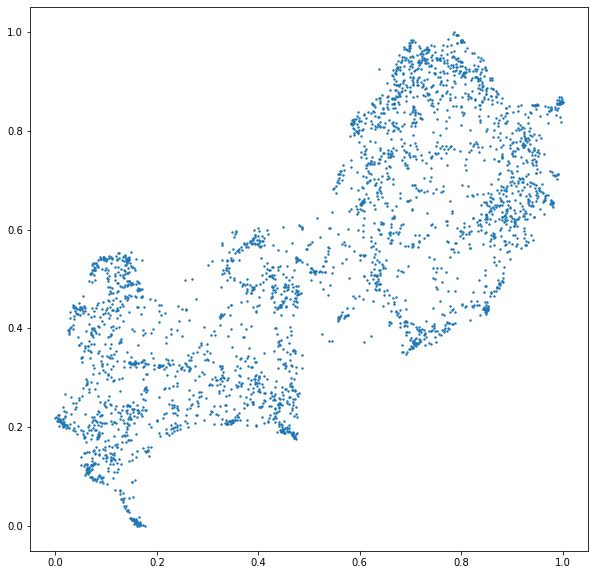

In [10]:
import umap

c_reducer = optimviz.reducer.ChannelReducer(
    n_components=2,
    reduction_alg=umap.UMAP,
    verbose=True,
    n_neighbors=20,
    min_dist=0.01,
    metric="cosine",
)
# You can also use TSNE instead of UMAP if desired:
# from sklearn.manifold import TSNE
# c_reducer = optimviz.reducer.ChannelReducer(
#    n_components=2,
#    reduction_alg=TSNE,
#    verbose=True,
#    metric="cosine",
#    learning_rate=10,
#    perplexity=50,
# )


reduced_filtered_samples = c_reducer.fit_transform(filtered_samples)

# Normalize umap reduced activation samples for graph
reduced_samples_normalized = optimviz.atlas.normalize_grid(reduced_filtered_samples)

# Show the normalized umap reduced activation samples
plt.figure(figsize=(10, 10))
plt.scatter(x=reduced_samples_normalized[:, 0], y=reduced_samples_normalized[:, 1], s=2)
plt.show()

## Activation Atlas Vectors & Coordinates

Now we can use both the filtered Mixed5b activation samples and our dimensionality reduced filtered activation samples to create the direction vectors for generating visualizations. The `create_atlas_vectors` function will return a set of direction vectors and a list of coordinations for creating the activation atlas image. 

When creating our atlas, the `grid_size` parameter defines how big our atlas should be. For class activations atlases, we'll aim for a smaller grid size.

In [25]:
grid_size = (8, 8)
vecs, vec_coords = optimviz.atlas.create_atlas_vectors(
    reduced_filtered_samples.to(device), filtered_samples, grid_size=grid_size, min_density=4
)

## Activation Atlas Heatmap & Shape

We can now easily see the shape of our atlas before rendering all of the images, then we can simply do this:

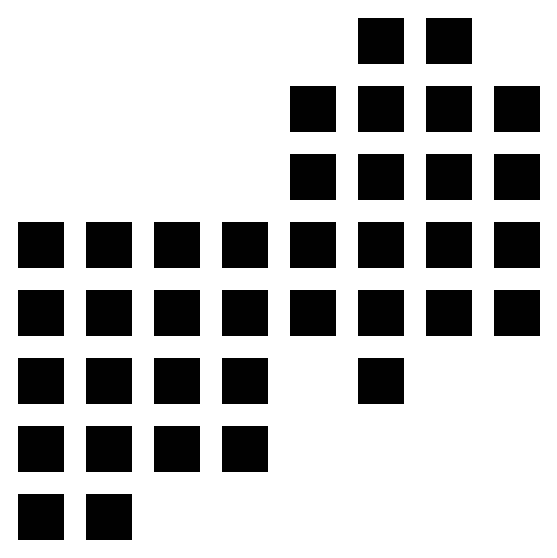

In [26]:
import torch.nn.functional as F
atlas_bw_tensors = [F.pad(torch.ones(1, 3, 4, 4) * 255, (1,1,1,1), value=1) for n in vec_coords]
atlas_bw = optimviz.atlas.create_atlas(atlas_bw_tensors, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_bw_mask = create_alpha_mask(6, 6, vec_coords=vec_coords, device=atlas_bw.device)
atlas_bw = torch.cat([atlas_bw, alpha_bw_mask], 1)

show(atlas_bw, figsize=(10, 10))

# Creating The Activation Atlas Visualizations

Now we should everything we need to start creating the visualizations for each activation atlas cell!

Below we define two helper functions to help us visualize all the atlas vectors that we created above by using the `create_atlas_vectors` function. To create the visualizations for our atlas we will use the `WhitenedNeuronDirection` objective.

In [31]:
def vis_neuron_direction(
    model: torch.nn.Module,
    target: torch.nn.Module,
    vec: torch.Tensor,
    vec_whitened: torch.Tensor,
) -> torch.Tensor:
    image = optimviz.images.NaturalImage((80, 80)).to(device)
    loss_fn = optimviz.loss.WhitenedNeuronDirection(
        target, vec, vec_whitened, cossim_pow=4.0
    )
    transforms = torch.nn.Sequential(
        torch.nn.ConstantPad2d(2, value=1.0),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(4),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.RandomScale(
            scale=[0.995 ** n for n in range(-5, 80)]
            + [0.998 ** n for n in 2 * list(range(20, 40))]
        ),
        optimviz.transform.RandomRotation(
            degrees=list(range(-20, 20))
            + list(range(-10, 10))
            + list(range(-5, 5))
            + 5 * [0]
        ),
        optimviz.transform.RandomSpatialJitter(2),
        optimviz.transform.CenterCrop((80,80)),
    )
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128, False))
    return image()._t

We whiten the raw Mixed5b activation samples for the `WhitenedNeuronDirection` objective:

In [29]:
# Whiten the raw activations
whitend_activation_samples = torch.inverse(
    torch.matmul(activation_samples.T, activation_samples)
    / len(activation_samples)
)

To generate all of the activation atlas images, we'll iterate through all the previously calculated direction vectors. To monitor our progress, we can use the `tqdm` library.

In [32]:
from tqdm import tqdm

A = []
for i in tqdm(range(vecs.size(0)), position=0, leave=True):
    img = vis_neuron_direction(
        model, model.mixed5b, vec=vecs[i], vec_whitened=whitend_activation_samples
    )
    A.append(img.detach().cpu())

100%|██████████| 37/37 [02:45<00:00,  4.47s/it]


Now we can put all the images together using the cell coordinates that we previously calculated!

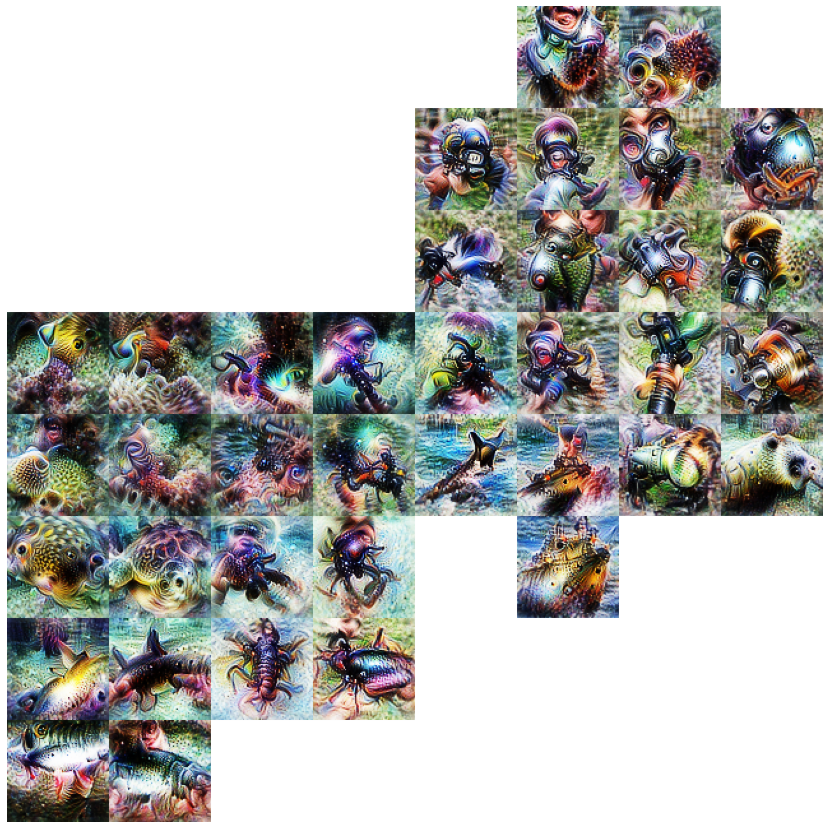

In [33]:
atlas_img = optimviz.atlas.create_atlas(A, vec_coords, grid_size=grid_size)

# Make background transparent
alpha_mask = create_alpha_mask(*A[0].shape[2:], vec_coords=vec_coords, device=atlas_img.device)
atlas_img = torch.cat([atlas_img, alpha_mask], 1)

# Save atlas as image and show it to user
save_tensor_as_image(atlas_img.detach(), "class_atlas.png")
show(atlas_img.detach(), figsize=(15, 15))